In [8]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
print(client)


<Client: 'tcp://127.0.0.1:44773' processes=7 threads=28, memory=125.20 GiB>


In [4]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage
repackage.add('../../')
repackage.add('../')

'/jobfs/102061847.gadi-pbs'

In [19]:
# load single ROMS netcdf with xr
ds_raw = xr.open_dataset('../../mdl/amery_hr_repeatyear/roms_avg_0015.nc')
ds_raw

ini = xr.open_dataset('../../frc/amery_v2km_ini.nc')

In [12]:
ini.nbytes/1e9

0.685378152

In [16]:
ds_raw

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 750,
                    xi_rho: 900, eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900,
                    eta_psi: 749, xi_psi: 899, ocean_time: 73)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    lon_rho        (eta_rho, xi_rho) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 ...
    lon_u          (eta_u, xi_u) float64 ...
    lat_u          (eta_u, xi_u) float64 ...
    lon_v          (eta_v, xi_v) float64 ...
    lat_v          (eta_v, xi_v) float64 ...
    lon_psi        (eta_psi, xi_psi) float64 ...
    lat_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2020-12-30T12:00:00 ... 2021-1...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/79)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    u              (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v              (ocean_time, s_rho, eta_v, xi_v) float32 ...
    omega          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    w              (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    temp           (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt           (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
Attributes: (12/35)
    file:              roms_avg_0015.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Tuesday - October 17, 2023 -  ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ANA_BSFLUX, ANA_BTFLUX, ANA_SRFLUX, ASSUMED_SHA...

In [20]:
ds_raw = ds_raw.drop_vars({'omega','w','ubar','vbar','u','v'})
ds_raw.nbytes/1e9

12.51442308

In [ ]:
# # do special processing for ROMS formatting


# def processROMSGrid(ds):
#     ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

#     coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
#         'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
#         'Z':{'center':'s_rho', 'outer':'s_w'}}

#     grid = Grid(ds, coords=coords, periodic=[])

#     if ds.Vtransform == 1:
#         Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
#         z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
#         Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
#         z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
#         del Zo_rho, Zo_w
#     elif ds.Vtransform == 2:
#         Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
#         z_rho = (ds.zeta+ds.zice) + ((ds.zeta+ds.zice) + ds.h) * Zo_rho
#         Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
#         z_w = Zo_w * ((ds.zeta+ds.zice) + ds.h) + (ds.zeta+ds.zice)
#         del Zo_rho, Zo_w
#     print('making vertical coordinates')
    
#     ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
#     ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
#     # Other Option is to transpose arrays and fill NaNs with a minimal depth
#     # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
#     # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
#     ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
#     ds["z_rho0"] = ds.z_rho0.fillna(0)
#     del z_rho, z_w

#      # interpolate depth of levels at U and V points
#     ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
#     ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
#     print('made V transform coordinates')

#     print('making x/y metrics')
#     ds['pm_v'] = grid.interp(ds.pm, 'Y')
#     ds['pn_u'] = grid.interp(ds.pn, 'X')
#     ds['pm_u'] = grid.interp(ds.pm, 'X')
#     ds['pn_v'] = grid.interp(ds.pn, 'Y')
#     ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
#     ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

#     ds['dx'] = 1/ds.pm
#     ds['dx_u'] = 1/ds.pm_u
#     ds['dx_v'] = 1/ds.pm_v
#     ds['dx_psi'] = 1/ds.pm_psi

#     ds['dy'] = 1/ds.pn
#     ds['dy_u'] = 1/ds.pn_u
#     ds['dy_v'] = 1/ds.pn_v
#     ds['dy_psi'] = 1/ds.pn_psi
#     print('making z metrics')

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

#     ds['dA'] = ds.dx * ds.dy

#     metrics = {
#         ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
#         ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
#         ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
#         ('X', 'Y'): ['dA'] # Areas
#     }
#     grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])
#     print('finished')
#     return ds,grid


# ds,grid = processROMSGrid(ds)



In [21]:
# do special processing for ROMS formatting


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + (ds.zeta+ds.zice) * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + (ds.zeta+ds.zice) * (1 + Zo_w/ds.h)
        del Zo_rho, Zo_w
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = (ds.zeta+ds.zice) + ((ds.zeta+ds.zice) + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * ((ds.zeta+ds.zice) + ds.h) + (ds.zeta+ds.zice)
        del Zo_rho, Zo_w
    print('making vertical coordinates')
    
    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)
    del z_rho, z_w

     # interpolate depth of levels at U and V points
    # ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    # ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    print('made V transform coordinates')

    print('making x/y metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi
    print('making z metrics')

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    # ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    # ds['dz_u'] = grid.interp(ds.dz, 'X')
    # ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    # ds['dz_v'] = grid.interp(ds.dz, 'Y')
    # ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz'],# 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])
    # print('drop some unused vars')
    # ds = ds.drop_vars({'dz_u','dz_w','dz_v','dz_w_u','dz_w_v','z_u','z_v'})
    print('finished')
    print('ds size:',ds.nbytes/1e9,'G')
    return ds,grid


ds,grid = processROMSGrid(ds_raw)
del ds_raw



making vertical coordinates
made V transform coordinates
making x/y metrics
making z metrics
finished
ds size: 49.817517512 G


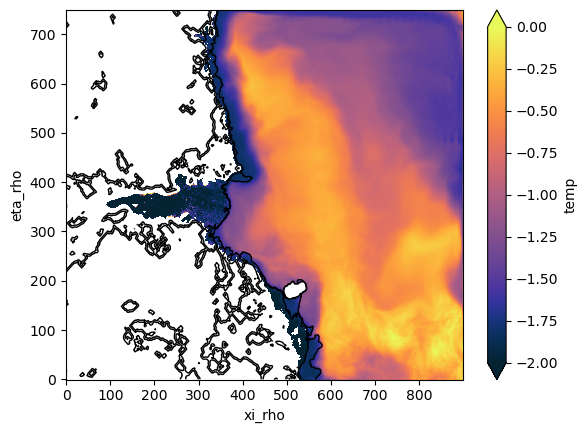

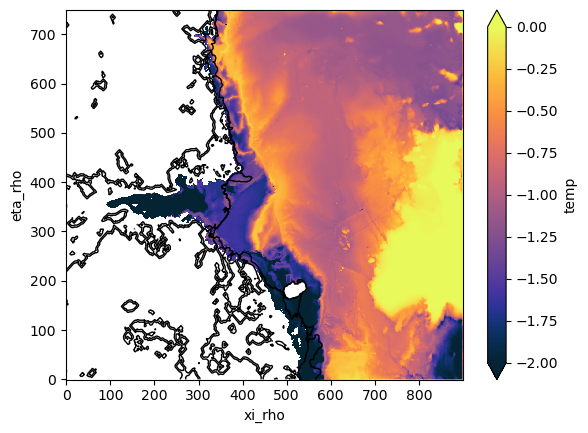

In [23]:
#plot mean temp/salt conditions at surface/bottom
ds.temp.isel(s_rho=-1).mean(dim='ocean_time').plot(cmap='cmo.thermal',vmin=-2,vmax=0)
ds.zice.plot.contour(levels=[-0.001,-50],colors='k',linestyles='-',linewidths=1)
plt.show()
ds.temp.isel(s_rho=0).mean(dim='ocean_time').plot(cmap='cmo.thermal',vmin=-2,vmax=0)
ds.zice.plot.contour(levels=[-0.001,-50],colors='k',linestyles='-',linewidths=1)


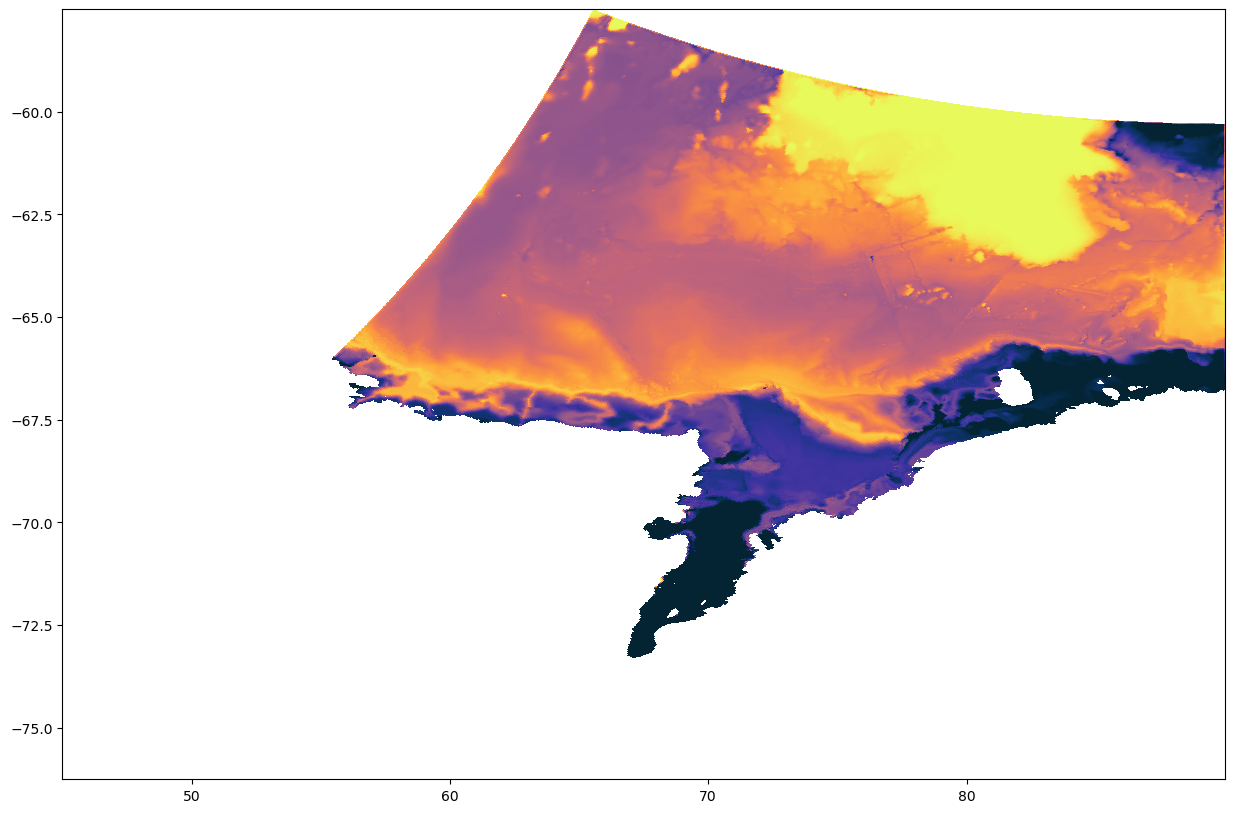

In [22]:
#plot mean temp/salt conditions at surface/bottom
plt.figure(figsize=(15,10))
plt.pcolormesh(ds.lon_rho,ds.lat_rho,ds.temp.isel(s_rho=0).mean(dim='ocean_time'),cmap='cmo.thermal',vmin=-2,vmax=0)

# ((grid.interp(ds.u.isel(s_rho=0).mean(dim='ocean_time'),'X')**2+grid.interp(ds.v.isel(s_rho=0).mean(dim='ocean_time'),'Y')**2)**0.5).plot(cmap='cmo.amp')
# plt.quiver(ds.lon_rho,ds.lat_rho,grid.interp(ds.u.isel(s_rho=0).mean(dim='ocean_time'),'X'),grid.interp(ds.v.isel(s_rho=0).mean(dim='ocean_time'),'Y'))

# ds.zice.plot.contour(levels=[-0.001,-50],colors='k',linestyles='-',linewidths=1)
plt.show()
# ds.temp.isel(s_rho=0).mean(dim='ocean_time').plot(cmap='cmo.thermal',vmin=-2,vmax=0)
# ds.zice.plot.contour(levels=[-0.001,-50],colors='k',linestyles='-',linewidths=1)


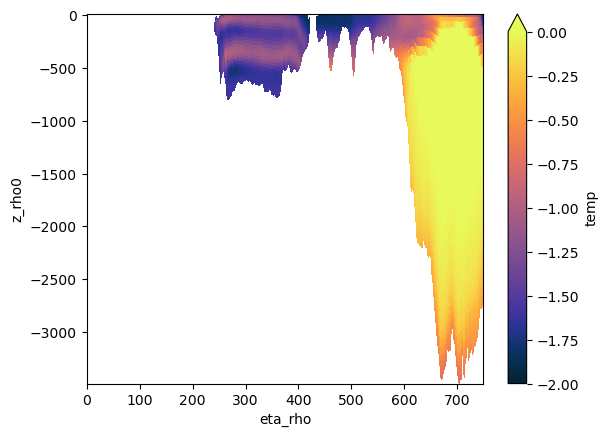

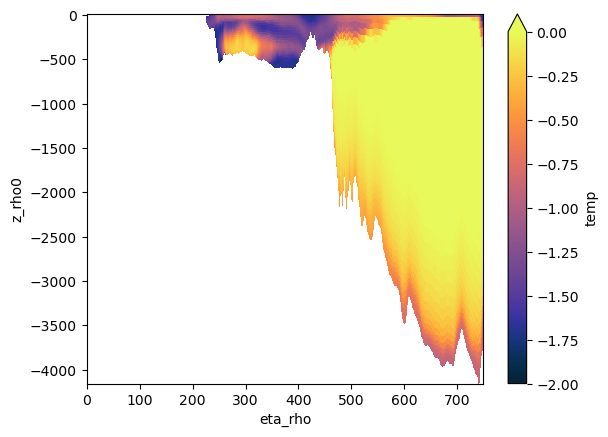

In [24]:
# plot transect of conditions
ds.temp.isel(xi_rho=390).mean(dim='ocean_time').plot(y='z_rho0',cmap='cmo.thermal',vmin=-2,vmax=0)
plt.show()
ds.temp.isel(xi_rho=430).mean(dim='ocean_time').plot(y='z_rho0',cmap='cmo.thermal',vmin=-2,vmax=0)


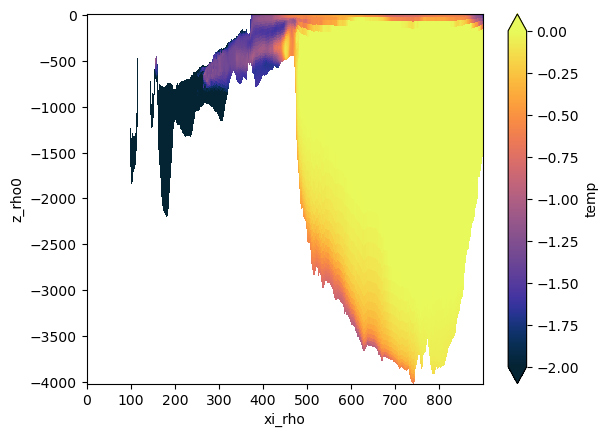

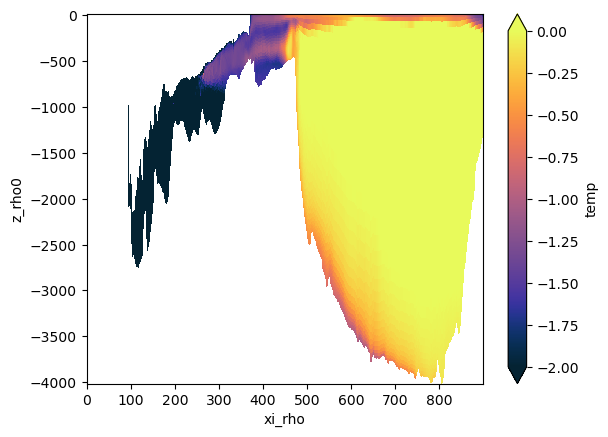

In [25]:
# plot transect of conditions
ds.temp.isel(eta_rho=350).mean(dim='ocean_time').plot(y='z_rho0',cmap='cmo.thermal',vmin=-2,vmax=0)
plt.show()
ds.temp.isel(eta_rho=360).mean(dim='ocean_time').plot(y='z_rho0',cmap='cmo.thermal',vmin=-2,vmax=0)


In [42]:
ds.lat_rho.isel(eta_rho=350).shape,ds.z_rho0.isel(eta_rho=350).T.shape,ini.temp.isel(eta_rho=350).squeeze().shape

((900,), (31, 900), (31, 900))

/jobfs/102061847.gadi-pbs/ipykernel_554143/2014117890.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds.lat_rho.isel(eta_rho=350),ds.z_rho0.isel(eta_rho=350).T,ini.temp.isel(eta_rho=350).squeeze(),cmap='cmo.thermal',vmin=-2,vmax=2)


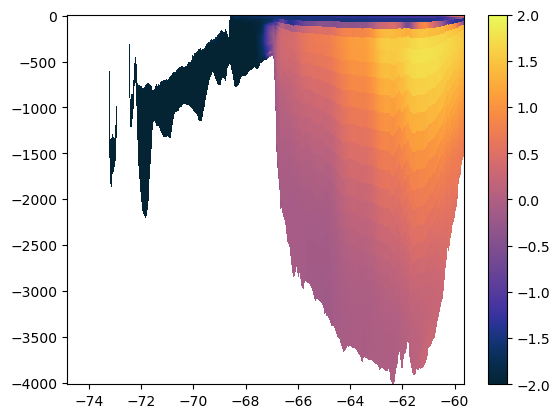

/jobfs/102061847.gadi-pbs/ipykernel_554143/2014117890.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds.lat_rho.isel(eta_rho=360),ds.z_rho0.isel(eta_rho=360).T,ini.temp.isel(eta_rho=360).squeeze(),cmap='cmo.thermal',vmin=-2,vmax=2)


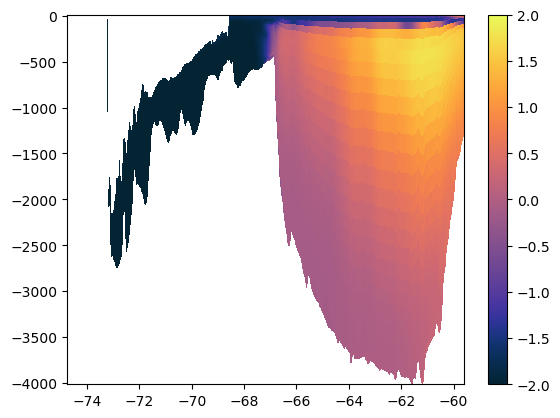

In [46]:
# plot transect of conditions
plt.pcolormesh(ds.lat_rho.isel(eta_rho=350),ds.z_rho0.isel(eta_rho=350).T,ini.temp.isel(eta_rho=350).squeeze(),cmap='cmo.thermal',vmin=-2,vmax=2)
plt.colorbar()
plt.show()
plt.pcolormesh(ds.lat_rho.isel(eta_rho=360),ds.z_rho0.isel(eta_rho=360).T,ini.temp.isel(eta_rho=360).squeeze(),cmap='cmo.thermal',vmin=-2,vmax=2)
plt.colorbar()

In [ ]:
STOP

In [ ]:
ds

In [ ]:
# plot heat content
#OHC = rho0*cp0*dV*dT
dV = ds.dA*ds.dz.mean(dim='ocean_time')
rho0=1026
cp0=4181.3
OHC=1026*4181.3*dV*(ds.temp+273.15)


In [ ]:
# plot total OHC
TotalOHC = OHC.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC.plot()
plt.show()
TotalOHC_1000 = OHC.where(ds.z_rho0>-1000, drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC_1000.plot()

In [ ]:
# plot under ice OHC

TotalOHC_subIce = OHC.where(ds.zice<0,drop=True).sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho')
TotalOHC_subIce.plot()



In [ ]:
# plot mean melt rates

In [ ]:
STOP

In [ ]:
# calculate mean of DJF, mean of JJA

# calculate the month length for each value
month_length = ds.ocean_time.dt.days_in_month


## Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("ocean_time.season") / month_length.groupby("ocean_time.season").sum()
)

## Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("ocean_time.season").sum().values, np.ones(4))

## Calculate the weighted average
ds_temp_weighted = (ds.temp * weights).groupby("ocean_time.season").sum(dim="ocean_time")
ds_salt_weighted = (ds.salt * weights).groupby("ocean_time.season").sum(dim="ocean_time")
ds_u_weighted = (ds.u_eastward * weights).groupby("ocean_time.season").sum(dim="ocean_time")
ds_v_weighted = (ds.v_northward * weights).groupby("ocean_time.season").sum(dim="ocean_time")


In [ ]:
# check what difference is
(ds_temp_weighted - ds.temp.groupby("ocean_time.season").mean("ocean_time")).sel(season='DJF').isel(s_rho=-1).plot()


In [ ]:
# mean summer surface temperature
ds_temp_weighted.isel(s_rho=-1).sel(season='DJF').plot(cmap='cmo.thermal',vmin=22,vmax=32)

In [ ]:
# mean winter surface temperature
ds_temp_weighted.isel(s_rho=-1).sel(season='JJA').plot(cmap='cmo.thermal',vmin=16,vmax=24)

In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
# ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ds_temp_weighted.isel(s_rho=-1).sel(season='DJF').plot(cmap='cmo.thermal',vmin=16,vmax=32)
# cax = inset_axes(ax,
#              width="5%",  # width = 10% of parent_bbox width
#              height="50%",  # height : 50%
#              loc='lower left',
#              bbox_to_anchor=(.07,.39, 1, 1),
#              bbox_transform=ax.transAxes,
#              borderpad=0,
#              )
# fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs[0,1])#, projection=ccrs.PlateCarree())
im = ds_temp_weighted.isel(s_rho=-1).sel(season='JJA').plot(cmap='cmo.thermal',vmin=16,vmax=32)
# cax = inset_axes(ax,
#              width="5%",  # width = 10% of parent_bbox width
#              height="50%",  # height : 50%
#              loc='lower left',
#              bbox_to_anchor=(.07,.39, 1, 1),
#              bbox_transform=ax.transAxes,
#              borderpad=0,
#              )
# fig.colorbar(im, cax=cax)

In [ ]:
# what is the depth of the top cells?
ds.z_rho0.isel(s_rho=-1).plot()

In [ ]:
def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output



In [ ]:

# gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
# plt.cla()
# plt.clf()
# fig = plt.figure(figsize=[8,6])
# ax = None


# ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
# # ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im = ds_temp_weighted.isel(s_rho=-1).sel(season='DJF').plot(cmap='cmo.thermal',vmin=16,vmax=32)
# # cax = inset_axes(ax,
# #              width="5%",  # width = 10% of parent_bbox width
# #              height="50%",  # height : 50%
# #              loc='lower left',
# #              bbox_to_anchor=(.07,.39, 1, 1),
# #              bbox_transform=ax.transAxes,
# #              borderpad=0,
# #              )
# # fig.colorbar(im, cax=cax)

# ax = fig.add_subplot(gs[0,1])#, projection=ccrs.PlateCarree())
# im = ds_temp_weighted.isel(s_rho=-1).sel(season='JJA').plot(cmap='cmo.thermal',vmin=16,vmax=32)
# # cax = inset_axes(ax,
# #              width="5%",  # width = 10% of parent_bbox width
# #              height="50%",  # height : 50%
# #              loc='lower left',
# #              bbox_to_anchor=(.07,.39, 1, 1),
# #              bbox_transform=ax.transAxes,
# #              borderpad=0,
# #              )
# # fig.colorbar(im, cax=cax)

horizontalSectionROMS(grid, ds_temp_weighted, np.array([-5])).sel(season='DJF').plot(cmap='cmo.thermal',vmin=16,vmax=32)

In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
# ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im = ds_salt_weighted.isel(s_rho=-1).sel(season='DJF').plot(cmap='cmo.haline',vmin=35,vmax=36)
# cax = inset_axes(ax,
#              width="5%",  # width = 10% of parent_bbox width
#              height="50%",  # height : 50%
#              loc='lower left',
#              bbox_to_anchor=(.07,.39, 1, 1),
#              bbox_transform=ax.transAxes,
#              borderpad=0,
#              )
# fig.colorbar(im, cax=cax)

ax = fig.add_subplot(gs[0,1])#, projection=ccrs.PlateCarree())
im = ds_salt_weighted.isel(s_rho=-1).sel(season='JJA').plot(cmap='cmo.haline',vmin=35,vmax=36)
# cax = inset_axes(ax,
#              width="5%",  # width = 10% of parent_bbox width
#              height="50%",  # height : 50%
#              loc='lower left',
#              bbox_to_anchor=(.07,.39, 1, 1),
#              bbox_transform=ax.transAxes,
#              borderpad=0,
#              )
# fig.colorbar(im, cax=cax)

In [ ]:
ds_grid = xr.open_dataset('../../seqld_zeroforcing_realIni/roms_his_0001.nc')
ds['lat_rho'] = ds_grid.lon_rho
ds['lat_rho'] = ds_grid.lat_rho


In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
# ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im = ds_salt_weighted.isel(s_rho=-1).sel(season='DJF').plot(cmap='cmo.haline',vmin=35,vmax=36)



inp = np.sqrt(ds_u_weighted.isel(s_rho=-1).squeeze()**2+ds_v_weighted.isel(s_rho=-1).squeeze()**2)
im = ax.pcolormesh(ds.lon_rho,ds.lat_rho,inp.sel(season='DJF'))

str_kwargs = {"color":inp.sel(season='DJF').values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink"}
st = ax.streamplot(ds.lon_rho.values, ds.lat_rho.values, ds_u_weighted.sel(season='DJF').isel(s_rho=-1).values, ds_v_weighted.sel(season='DJF').isel(s_rho=-1).values,**str_kwargs)


In [ ]:

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[8,6])
ax = None


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
# ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im = ds_salt_weighted.isel(s_rho=-1).sel(season='DJF').plot(cmap='cmo.haline',vmin=35,vmax=36)



inp = np.sqrt(ds_u_weighted.isel(s_rho=-1).squeeze()**2+ds_v_weighted.isel(s_rho=-1).squeeze()**2)
im = ax.pcolormesh(ds.lon_rho,ds.lat_rho,inp.sel(season='JJA'))
ax.contour(ds.lon_rho,ds.lat_rho,ds.h,levels=np.array((100,500,1000,2000,3000,4000)),colors='grey',linewidths=0.5)
str_kwargs = {"color":inp.sel(season='JJA').values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink"}
st = ax.streamplot(ds.lon_rho.values, ds.lat_rho.values, ds_u_weighted.sel(season='JJA').isel(s_rho=-1).values, ds_v_weighted.sel(season='JJA').isel(s_rho=-1).values,**str_kwargs)
